# 超解像畳み込みニューラルネットワーク

In [84]:
from keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.python.keras import backend as K
import numpy as np

def rescale(image, scale):
  (width, height) = (image.width, image.height)
  (small_width, small_height) = (int(width / scale), int(height / scale))
  return image.resize((small_width, small_height), 3)

def drop_resolution(x, scale=3.0):
  image = array_to_img(x)
  small_image = rescale(image, scale)
  return img_to_array(small_image.resize(image.size, 3))

def data_generator(data_dir, mode, scale=2.0, target_size=(200, 200), batch_size=32, shuffle=True):
  for imgs in ImageDataGenerator().flow_from_directory(
    directory=data_dir,
    classes=[mode],
    class_mode=None,
    color_mode="rgb",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=shuffle
  ):
    x = np.array([drop_resolution(img, scale) for img in imgs])
    yield x / 255., imgs / 255.

def psnr(y_true, y_pred):
  """
  パラメータは共に Tensor を取る。Custom Metrics 参照: https://keras.io/metrics/#custom-metrics
  """
  return -10 * K.log(K.mean(K.flatten((y_true - y_pred)) ** 2)) / np.log(10)


In [85]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.preprocessing.image import ImageDataGenerator
import os

DATA_DIR = "../../../datasets/openimages_v4/"
N_TRAIN_DATA = 1000
N_TEST_DATA = 100
BATCH_SIZE = 32

OUTPUT_FILE = "srcnn_openimages-v4.h5"

train_data_generator = data_generator(DATA_DIR, "challenge2018", batch_size=BATCH_SIZE)
test_x, test_y = next(data_generator(DATA_DIR, "challenge2018", batch_size=N_TEST_DATA, shuffle=False))

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=9, padding="same", activation="relu", input_shape=(None, None, 3)))
model.add(Conv2D(filters=32, kernel_size=1, padding="same", activation="relu"))
model.add(Conv2D(filters=3, kernel_size=5, padding="same"))
model.summary()

if not os.path.isfile(OUTPUT_FILE):
  model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=[psnr]
  )
  model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA // BATCH_SIZE,
    epochs=50
  )
  # カスタムメトリクスが load_model() で復元できないため重みだけ保存
  model.save_weights(OUTPUT_FILE)
else:
  model.load_weights(OUTPUT_FILE)

Found 99999 images belonging to 1 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
Found 99999 images belonging to 1 classes.
31/31 [==============================] - 28s 913ms/step - loss: 0.0301 - psnr: 16.2271 - val_loss: 0.0146 - val_psnr: 18.3512
Epoch 2/50
31/31 [==============================] - 23s 743ms/step - loss: 0.0126 - psnr: 19.0708 - val_loss: 0.0107 - val_psnr: 19.7058
Epoch 3/50
31/31 [========================

(1, 200, 200, 3) (1, 200, 200, 3)


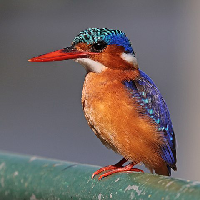

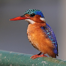

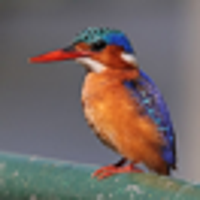

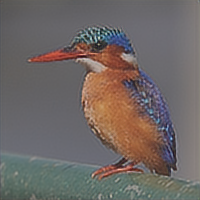

PSNR: 26.693072


In [88]:
from IPython.display import Image, display_png
from keras.preprocessing.image import load_img
import tensorflow as tf

image = load_img("kawasemi.jpg", target_size=(200, 200))
src = np.array([img_to_array(image) / 255.])

pred = model.predict(src)
print(pred.shape, src.shape)

display_png(image)
display_png(rescale(image, 3.0))
display_png(array_to_img(drop_resolution(src[0]) * 255.))
display_png(array_to_img(pred[0] * 255.))
print("PSNR: %f" % (-10 * np.log(np.mean((src - pred).flatten() ** 2)) / np.log(10)))